# LightGBM forecast
Author: Oscar Janossy   
Date: 2025-05-19  
Description: System imbalance forecating using LightGBM and Skforecat

## Import librairies and data

In [ ]:
# Core Python & System
import os
import sys
import warnings
from itertools import cycle
from pathlib import Path

# Data & Utilities
import numpy as np
import pandas as pd

# Progress Bar
from tqdm.autonotebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff

# Modeling & Forecasting
import sklearn
import lightgbm as lgb
from lightgbm import LGBMRegressor
import skforecast
from skforecast.feature_selection import select_features
from skforecast.model_selection import (
    TimeSeriesFold,
    backtesting_forecaster,
    bayesian_search_forecaster,
)
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error


# ----------------------------------------------------------------------------
# Configuration
# ----------------------------------------------------------------------------
warnings.filterwarnings("once")

# Plotly in-notebook setup
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)

# Matplotlib style
plt.style.use("seaborn-v0_8-darkgrid")

# Version info
print(f"skforecast version:   {skforecast.__version__}")
print(f"scikit-learn version: {sklearn.__version__}")
print(f"lightgbm version:     {lgb.__version__}")


skforecast version:   0.15.1
scikit-learn version: 1.6.1
lightgbm version:     4.6.0


In [58]:
# Global Configs
np.random.seed(42)
tqdm.pandas()

# Path Setup
directory = os.getcwd()
sys.path.insert(0, directory)
directory = '/Users/oscar/Documents/VS Code/Thesis/'

In [3]:
data = pd.read_csv(directory + '/data/data_ml_engineered.csv', parse_dates=['start_date'], index_col=0)
data.head()

,start_date,Imbalance,ISP (lag1),Day-ahead Spot Price,WIND_ONSHORE - D-1,WIND_ONSHORE - ID,WIND_ONSHORE - CURRENT,SOLAR - D-1,SOLAR - ID,SOLAR - CURRENT,...,day_weekend,day_holiday,Month_sin,Month_cos,Week_sin,Week_cos,Dayofweek_sin,Dayofweek_cos,1/2 Hour of the day_sin,1/2 Hour of the day_cos
0,2017-12-31 23:00:00+00:00,-377.32,29.22,6.74,10081.0,9839.0,9839.0,0.0,0.0,0.0,...,1,0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.781831,0.62349,-1.305262e-01,0.991445
1,2017-12-31 23:30:00+00:00,-468.52,29.22,6.74,10047.5,9820.5,9820.5,0.0,0.0,0.0,...,1,0,-2.449294e-16,1.000000,-2.449294e-16,1.000000,-0.781831,0.62349,-2.449294e-16,1.000000
2,2018-01-01 00:00:00+00:00,-1467.79,18.11,4.74,10014.0,9802.0,9802.0,0.0,0.0,0.0,...,0,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,1.305262e-01,0.991445
3,2018-01-01 00:30:00+00:00,-1467.09,20.49,4.74,9805.0,9717.5,9717.5,0.0,0.0,0.0,...,0,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,2.588190e-01,0.965926
4,2018-01-01 01:00:00+00:00,-1230.20,23.22,3.66,9596.0,9633.0,9633.0,0.0,0.0,0.0,...,0,1,5.000000e-01,0.866025,1.205367e-01,0.992709,0.000000,1.00000,3.826834e-01,0.923880


In [7]:
target = 'Imbalance'

## Test/Train Dataset

In [16]:
df = data.copy()

df.set_index('start_date', inplace=True)
df = df.asfreq('30min')

# Define the columns to keep
columns = ['Imbalance', 'Imbalance_lag_1'] 
    
# Calculate the split indices
train_size = int(0.7 * len(df))
val_size = int(0.15 * len(df))
test_size = len(df) - train_size - val_size



# Split the data
train_df = df.iloc[:train_size].dropna()
val_df = df.iloc[train_size:train_size + val_size]#[columns]
test_df = df.iloc[train_size + val_size:]#[columns]

df.dropna(inplace=True)
#Float32 conversion
train_df.astype({'Imbalance': 'float32'})
val_df.astype({'Imbalance': 'float32'})
test_df.astype({'Imbalance': 'float32'})


# Print the shapes to verify
print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("Test shape:", test_df.shape)



Train shape: (85848, 152)
Validation shape: (18396, 152)
Test shape: (18396, 152)


## Naive Model

In [ ]:
# Naive Forecasting

metrics = []
target = 'Imbalance'
target_lag  = target + '_lag_1'


# Validation metrics
y_val = val_df[target]
y_pred = val_df[target_lag]
# Calculate metrics
mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)
metrics.append((mae, rmse))

print()
print("Validation MAE:", mae)
print("Validation RMSE:", rmse)

# Test metrics
y_test = test_df[target]
y_pred = test_df[target_lag]
# Calculate metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
metrics.append((mae, rmse))

print()
print("Test MAE:", mae)
print("Test RMSE:", rmse)


Validation MAE: 288.79400684931505
Validation RMSE: 369.54421999033025

Test MAE: 256.60718634485755
Test RMSE: 330.3836068912438


In [ ]:
y_pred.to_csv(directory + '/data/predictions.csv')


Validation target std: 461.8559893621382
Test target std: 445.7563755369039



### LightGBM using Skforecast

Code developped using the example from the documentation of thr librairy

Forecasting time series with gradient LightGBM by Joaquín Amat Rodrigo and Javier Escobar Ortiz.  
Available under a [Attribution-NonCommercial-ShareAlike 4.0 International License](https://www.cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html).

In [ ]:
# Print the shapes to verify the splits


print(f"Dates train      : {train_df.index.min()} --- {train_df.index.max()}  (n={len(train_df)})")
print(f"Dates validacion : {val_df.index.min()} --- {val_df.index.max()}  (n={len(val_df)})")
print(f"Dates test       : {test_df.index.min()} --- {test_df.index.max()}  (n={len(test_df)})")

Dates train      : 2017-12-31 23:00:00+00:00 --- 2022-11-24 10:30:00+00:00  (n=85848)
Dates validacion : 2022-11-24 11:00:00+00:00 --- 2023-12-12 16:30:00+00:00  (n=18396)
Dates test       : 2023-12-12 17:00:00+00:00 --- 2024-12-29 22:30:00+00:00  (n=18396)


In [ ]:
# Remove warnings
warnings.simplefilter('ignore', category=UserWarning)


First model with autoregressive features. 1 week of data and rolling features.

In [18]:
window_features = RollingFeatures(stats=["mean", "min", "min", "max", "max"], window_sizes=[48, 48, 48*7, 48, 48*7,], min_periods=1)


forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = 48*7,
                window_features = window_features
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:train_df.index.max(), 'Imbalance'])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336] 
Window features: ['roll_mean_48', 'roll_min_48', 'roll_min_336', 'roll_max_48', 'roll_max_336'] 
Window size: 336 
Exogenous included: False 
Exogenous names: None 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2017-12-31 23:00:00+0000', tz='UTC'), Timestamp('2022-11-24 10:30:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 15926, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample':
    1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-17 15:54:26 
Last fit date: 2025-05-17 15:54:28 
Skforecast version: 0.15.1 
Python version: 3.12.0 
Forecaster id: None

In [19]:

# Backtest model on test data
# ==============================================================================
cv = TimeSeriesFold(
        steps              = 1,
        initial_train_size = len(df[:train_df.index.max()]),
        refit              = False,
)
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.loc[:val_df.index.max(), 'Imbalance'],
                            cv         = cv,
                            metric     = ['mean_absolute_error', root_mean_squared_error],
                       )
metric

  0%|          | 0/18396 [00:00<?, ?it/s]

,mean_absolute_error,root_mean_squared_error
0,204.543029,269.386883


In [54]:
exogenous_columns = list(df.columns[1:30]) 
cyclical_columns = [col for col in df.columns if col.endswith('_sin')]
categorical_columns = ['day_weekend', 'day_weekday', 'day_holiday']
exogenous_columns = exogenous_columns + cyclical_columns + categorical_columns #+['sign']
exogenous_columns = [col for col in exogenous_columns if col not in ['WIND_ONSHORE - D-1', 'WIND_ONSHORE - ID', 'SOLAR - D-1', 'SOLAR - ID', 'WIND Total D-1', 'WIND Total ID', 'Consumption D-1', 'upward_volume_balancing (lag1)']] 
exogenous_columns




['ISP (lag1)',
 'Day-ahead Spot Price',
 'WIND_ONSHORE - CURRENT',
 'SOLAR - CURRENT',
 'WIND CURRENT',
 'Consumption ID',
 'DA Total Load Forecast',
 'DA Total Generation Forecast',
 'AGGREGATED_PROGRAMMABLE_FRANCE - D-1',
 'AGGREGATED_NON_PROGRAMMABLE_FRANCE - D-1',
 'downward_volume_balancing (lag1)',
 'SOLAR DEVIATION (lag1)',
 'SOLAR DEVIATION CURRENT (lag1)',
 'WIND DEVIATION (lag1)',
 'WIND DEVIATION CURRENT (lag1)',
 'LOAD DEVIATION (lag1)',
 'CONSUMPTION DEVIATION (lag1)',
 'PROGRAMMABLE RATIO D-1',
 'NUCLEAR - SHARE % (lag1)',
 'GAS -SHARE % (lag1)',
 'SOLAR - SHARE % (lag1)',
 'Month_sin',
 'Week_sin',
 'Dayofweek_sin',
 '1/2 Hour of the day_sin',
 'day_weekend',
 'day_weekday',
 'day_holiday']

In [59]:
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=42, verbose=-1),
                lags            = 48*7,
                window_features = window_features,
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:train_df.index.max(), 'Imbalance'],
               exog = df.loc[:train_df.index.max(), exogenous_columns])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252
 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270
 271 272 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288
 289 290 291 292 293 294 295 296 297 298 299 300 301 302 303 304 305 306
 307 308 309 310 311 312 313 314 315 316 317 318 319 320 321 322 323 324
 325 326 327 328 329 330 331 332 333 334 335 336] 
Window features: ['roll_mean_48', 'roll_min_48', 'roll_min_336', 'roll_max_48', 'roll_max_336'] 
Window size: 336 
Exogenous included: True 
Exogenous names: 
    ISP (lag1), Day-ahead Spot Price, WIND_ONSHORE - CURRENT, SOLAR - CURRENT, WIND
    CURRENT, Consumption ID, DA Total Load Forecast, DA Total Generation
    Forecast, AGGREGATED_PROGRAMMABLE_FRANCE - D-1,
    AGGREGATED_NON_PROGRAMMABLE_FRANCE - D-1, downward_volume_balancing (lag1),
    SOLAR DEVIATION (lag1), SOLAR DEVIATION CURRENT (lag1), WIND DEVIATION
    (lag1), WIND DEVIATION CURRENT (lag1), LOAD DEVIATION (lag1), CONSUMPTION
    DEVIATION (lag1), PROGRAMMABLE RATIO D-1, NUCLEAR - SHARE % (lag1), GAS
    -SHARE % (lag1), SOLAR - SHARE % (lag1), Month_sin, Week_sin, Dayofweek_sin,
    1/2 Hour of the day_sin, day_weekend, day_weekday, day_holiday 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2017-12-31 23:00:00+0000', tz='UTC'), Timestamp('2022-11-24 10:30:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-17 16:11:51 
Last fit date: 2025-05-17 16:11:53 
Skforecast version: 0.15.1 
Python version: 3.12.0 
Forecaster id: None

In [60]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.loc[:val_df.index.max(), 'Imbalance'],
                            cv         = cv,
                            metric     = ['mean_absolute_error', root_mean_squared_error],
                            exog       = df.loc[:val_df.index.max(), exogenous_columns],
                            

                       )
metric

  0%|          | 0/18396 [00:00<?, ?it/s]

,mean_absolute_error,root_mean_squared_error
0,202.781334,267.153215


In [61]:
# Get the most important features

importance = forecaster.get_feature_importances()
top_20_features = importance['feature'].head(20).tolist()
top_20_features

['lag_1',
 'lag_48',
 '1/2 Hour of the day_sin',
 'lag_49',
 'LOAD DEVIATION (lag1)',
 'lag_2',
 'lag_288',
 'lag_289',
 'lag_4',
 'lag_144',
 'lag_96',
 'lag_97',
 'lag_145',
 'lag_336',
 'lag_3',
 'lag_240',
 'lag_192',
 'lag_193',
 'lag_241',
 'lag_335']

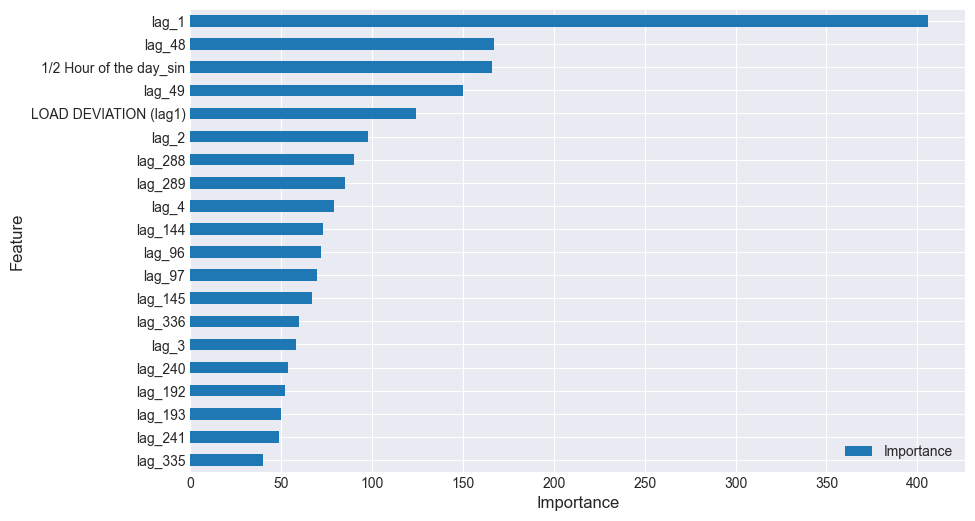

In [ ]:
#Plot the feature importances

importance_plot = importance.head(20)

# Sort values and filter out 'Hour_sin'
importance_plot = importance_plot.sort_values(by='importance', ascending=True)

# Plot
ax = importance_plot.plot(
    x='feature', 
    y='importance', 
    kind='barh', 
    figsize=(10, 6), 
    legend=False
)

# Add labels
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)

# Add legend
ax.legend(['Importance'], loc='lower right')

plt.show()

In [63]:
lag_numbers = [int(feature.split('_')[1]) for feature in top_20_features if feature.startswith('lag_')]
exog_other = [feature for feature in top_20_features if feature not in [f'lag_{num}' for num in lag_numbers]]
lag_numbers, exog_other

([1,
  48,
  49,
  2,
  288,
  289,
  4,
  144,
  96,
  97,
  145,
  336,
  3,
  240,
  192,
  193,
  241,
  335],
 ['1/2 Hour of the day_sin', 'LOAD DEVIATION (lag1)'])

### Retrain only with the most important features

In [64]:
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=42, verbose=-1),
                lags            = lag_numbers,
                #window_features = window_features,
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:train_df.index.max(), 'Imbalance'],
               exog = df.loc[:train_df.index.max(), exog_other])
forecaster

=================== 
ForecasterRecursive 
=================== 
Regressor: LGBMRegressor 
Lags: [  1   2   3   4  48  49  96  97 144 145 192 193 240 241 288 289 335 336] 
Window features: None 
Window size: 336 
Exogenous included: True 
Exogenous names: 1/2 Hour of the day_sin, LOAD DEVIATION (lag1) 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Differentiation order: None 
Training range: [Timestamp('2017-12-31 23:00:00+0000', tz='UTC'), Timestamp('2022-11-24 10:30:00+0000', tz='UTC')] 
Training index type: DatetimeIndex 
Training index frequency: 30min 
Regressor parameters: 
    {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0,
    'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1,
    'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0,
    'n_estimators': 100, 'n_jobs': None, 'num_leaves': 31, 'objective': None,
    'random_state': 42, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'subsample': 1.0,
    'subsample_for_bin': 200000, 'subsample_freq': 0, 'verbose': -1} 
fit_kwargs: {} 
Creation date: 2025-05-17 16:12:59 
Last fit date: 2025-05-17 16:13:00 
Skforecast version: 0.15.1 
Python version: 3.12.0 
Forecaster id: None

In [65]:
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df.loc[:val_df.index.max(), 'Imbalance'],
                            cv         = cv,
                            metric     = ['mean_absolute_error', root_mean_squared_error],
                            exog       = df.loc[:val_df.index.max(), exog_other],
                            

                       )
metric



  0%|          | 0/18396 [00:00<?, ?it/s]

,mean_absolute_error,root_mean_squared_error
0,204.634888,269.214594


### Hypereparameter tuning

In [ ]:
# Hyperparameters search
# ==============================================================================
# Create forecaster
forecaster = ForecasterRecursive(
                regressor       = LGBMRegressor(random_state=15926, verbose=-1),
                lags            = lag_numbers,

                
            )




# Regressor hyperparameters search space
def search_space(trial):
    search_space  = {
        'n_estimators'    : trial.suggest_int('n_estimators', 400, 2000, step=100),
        'max_depth'       : trial.suggest_int('max_depth', 3, 15, step=1),
        'num_leaves'      : trial.suggest_int('num_leaves', 8, 256, step=8),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 500, step=5),
        'learning_rate'   : trial.suggest_float('learning_rate', 0.01, 0.2, step=0.01),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.3, 1, step=0.1),
        'max_bin'         : trial.suggest_int('max_bin', 50, 250, step=25),
        'reg_alpha'       : trial.suggest_float('reg_alpha', 0, 1, step=0.1),
        'reg_lambda'      : trial.suggest_float('reg_lambda', 0, 1, step=0.1),
    } 
    return search_space

# Folds
cv_search = TimeSeriesFold(
                steps              = 1,
                initial_train_size = len(train_df),
                refit              = False,
            )

results_search, frozen_trial = bayesian_search_forecaster(
                                    forecaster    = forecaster,
                                    y             = df.loc[:val_df.index.max(), 'Imbalance'],
                                    exog          = df.loc[:val_df.index.max(), exog_other],
                                    search_space  = search_space,
                                    cv            = cv_search,
                                    metric        = [root_mean_squared_error, 'mean_absolute_error', 'mean_absolute_scaled_error'],
                                    n_trials      = 50,
                                )
best_params = results_search['params'].iat[0]


  0%|          | 0/50 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4  48  49  96  97 144 145 192 193 240 241 288 289 335 336] 
  Parameters: {'n_estimators': 1600, 'max_depth': 10, 'num_leaves': 152, 'min_data_in_leaf': 60, 'learning_rate': 0.01, 'feature_fraction': 0.7, 'max_bin': 250, 'reg_alpha': 0.5, 'reg_lambda': 0.5}
  Backtesting metric: 265.59008248948106


In [37]:
results_search

,lags,params,root_mean_squared_error,mean_absolute_error,mean_absolute_scaled_error,n_estimators,max_depth,num_leaves,min_data_in_leaf,learning_rate,feature_fraction,max_bin,reg_alpha,reg_lambda
0,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 7, 'num_le...",265.521879,201.640528,0.693320,1100.0,7.0,24.0,425.0,0.04,0.8,175.0,0.6,0.6
1,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 6, 'num_le...",265.777959,201.721568,0.693599,1100.0,6.0,24.0,250.0,0.04,0.7,200.0,0.6,0.6
2,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 9, 'num_le...",265.825974,201.718203,0.693588,1100.0,9.0,152.0,245.0,0.02,0.6,225.0,0.4,0.6
3,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1000, 'max_depth': 3, 'num_le...",265.826470,201.930064,0.694316,1000.0,3.0,32.0,315.0,0.09,0.7,200.0,1.0,0.7
4,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 4, 'num_le...",265.853947,201.826862,0.693961,1100.0,4.0,48.0,65.0,0.08,0.6,225.0,0.9,0.8
5,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 4, 'num_le...",265.900141,201.854485,0.694056,1100.0,4.0,64.0,100.0,0.07,0.6,225.0,1.0,0.8
6,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1100, 'max_depth': 7, 'num_le...",265.964742,201.928484,0.694311,1100.0,7.0,16.0,415.0,0.04,0.8,200.0,0.7,0.6
7,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 900, 'max_depth': 4, 'num_lea...",266.031514,202.150290,0.695073,900.0,4.0,96.0,230.0,0.05,0.7,225.0,1.0,0.8
8,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1000, 'max_depth': 5, 'num_le...",266.155218,202.147728,0.695064,1000.0,5.0,40.0,285.0,0.07,0.9,175.0,0.5,0.6
9,"[1, 2, 3, 4, 48, 49, 96, 97, 144, 145, 192, 19...","{'n_estimators': 1000, 'max_depth': 7, 'num_le...",266.162419,201.956560,0.694407,1000.0,7.0,32.0,495.0,0.03,0.8,175.0,0.5,0.4


## Refit using best parameters on training and validation set

In [41]:
forecaster = ForecasterRecursive(
               regressor       = LGBMRegressor(random_state=42,colsample_bytree=None, min_child_samples=None, **best_params),
               lags            = lag_numbers,
               
             )

# Train forecaster
# ==============================================================================
forecaster.fit(y=df.loc[:val_df.index.max(), 'Imbalance'],
               exog = df.loc[:val_df.index.max(), exog_other])

#CV
cv = TimeSeriesFold(
        steps              = 1,
        initial_train_size = len(df[:val_df.index.max()]),
        refit              = False,
)


# Backtesting model with exogenous variables on test data
# ==============================================================================
metric, predictions = backtesting_forecaster(
                            forecaster = forecaster,
                            y          = df['Imbalance'],
                            exog       = df[exog_other],
                            cv         = cv,
                            metric     = [root_mean_squared_error,'mean_absolute_error', 'mean_absolute_scaled_error']
                       )

display(metric)


  0%|          | 0/18396 [00:00<?, ?it/s]

,root_mean_squared_error,mean_absolute_error,mean_absolute_scaled_error
0,269.106642,203.71244,0.701316


In [42]:
# Plot predictions vs real value
# ======================================================================================
fig = go.Figure()
trace1 = go.Scatter(x=test_df.index, y=test_df['Imbalance'], name="test", mode="lines")
trace2 = go.Scatter(x=predictions.index, y=predictions['pred'], name="prediction", mode="lines")
fig.add_trace(trace1)
fig.add_trace(trace2)
fig.update_layout(
    title="Real value vs predicted in test data",
    xaxis_title="Date time",
    yaxis_title="Users",
    width=800,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1.1, xanchor="left", x=0.001)
)
fig.show()


### Save predictions

In [43]:
predictions.to_csv(directory + '/data/predictions_lgbm.csv')